# Keras and QKeras test comparison with lstm


## Preprocessing


Import cell


In [2]:
import tensorflow as tf
import keras
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')

print("Available devices:", gpus)
# limit VRAM usage if GPU is available
if len(gpus) > 0:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*0.5)])

#tensorflow.config.gpu.set_per_process_memory_fraction(0.75)
#tensorflow.config.gpu.set_per_process_memory_growth(True)
#tensorflow.GPUOptions(per_process_gpu_memory_fraction=0.33)
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque
import time
import random
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib as plt


2022-04-20 13:39:33.122633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-20 13:39:33.122649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Available devices: []


2022-04-20 13:39:36.861960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-20 13:39:36.861978: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 13:39:36.861990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marsattack3): /proc/driver/nvidia/version does not exist


In [1]:
import os
print(os.environ['LD_LIBRARY_PATH'])
print('and\n', os.environ['PATH'])

/cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
and
 /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/altera/21.1.0.169.pro/gcc/bin:/inteltools/altera/21.1.0.169.pro/hls/bin:/inteltools/altera/21.1.0.169.pro/qsys/bin:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/mentor/2018-19/RHELx86/QUESTA-CORE-PRIME_10.7c/questasim/linux_x86_64:/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/bin:/atlas/bonnet/miniconda3/condabin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


Data inputs


In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

"""
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

#removing one dim for lstm
x_train = np.zeros( (60000, 28, 28, 1) )
x_train = x_train[:, :, :, 0]
x_test = np.zeros( (10000, 28, 28, 1) )
x_test = x_test[:, :, :, 0]

"""
#creating the validation sample
x_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2018)

print(x_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(X_val.shape [0], "validation sample")

y_train= tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

print(x_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(54000, 28, 28)
(6000, 28, 28)
(54000,)
(6000,)
54000 train samples
10000 test samples
6000 validation sample
(54000, 28, 28)
(6000, 28, 28)
(54000, 10)
(6000, 10)


In [6]:
with open("inputs.txt", "w") as inputs_file :
    for i in range(1000):
        save_inputs = str(float(y_val[i]))
        inputs_file.write("{}\n".format(save_inputs))

TypeError: only size-1 arrays can be converted to Python scalars

## Classic Model


In [3]:

model = Sequential()

model.add(LSTM(10, input_shape=(28, 28), return_sequences=False))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()



2022-04-11 09:53:47.747946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                1560      
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
Total params: 1,670
Trainable params: 1,670
Non-trainable params: 0
_________________________________________________________________


/atlas/bonnet/miniconda3/envs/cppm_env_39/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training 


In [4]:
checkpoint_filepath = '/atlas/bonnet/tmp/rnn_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)




reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)



## QKeras testing 


Imports


In [5]:
import qkeras
from qkeras import *


Model

In [6]:
qmodel = Sequential ()

bits_parameter1 = (8, 2, 0, 1)

qmodel.add(QLSTM(10, input_shape=(28, 28), 
                return_sequences=False,
                kernel_quantizer=quantized_bits(*bits_parameter1),
                recurrent_quantizer=quantized_bits(*bits_parameter1),
                bias_quantizer=quantized_bits(*bits_parameter1),
                state_quantizer=quantized_bits(*bits_parameter1),))

qmodel.add(QDense(10, activation='softmax',
                    kernel_quantizer=quantized_bits(*bits_parameter1),
                    bias_quantizer=quantized_bits(*bits_parameter1)))

qmodel.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=['accuracy'])
qmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qlstm (QLSTM)               (None, 10)                1560      
                                                                 
 q_dense (QDense)            (None, 10)                110       
                                                                 
Total params: 1,670
Trainable params: 1,670
Non-trainable params: 0
_________________________________________________________________


In [7]:
qcheckpoint_filepath = '/atlas/bonnet/tmp/qmodel_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=qcheckpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)




reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)


## Comparison of the models


Implementation of the graphs


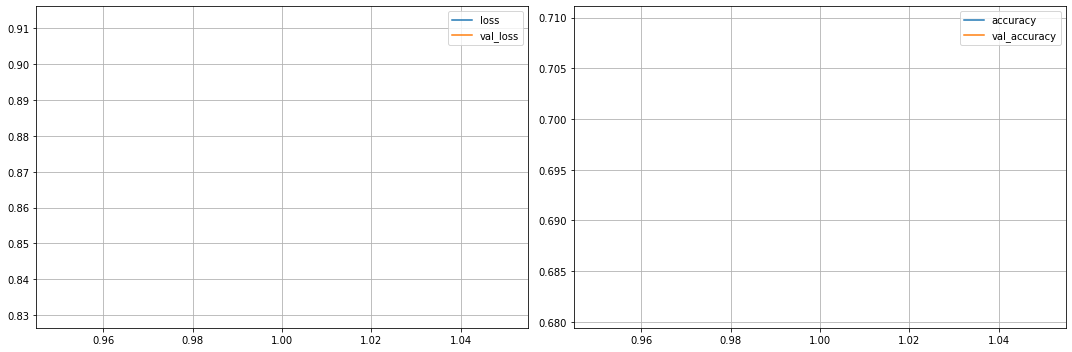

422/422 [==============================] - 6s 14ms/step - loss: 0.9120 - accuracy: 0.6809 - val_loss: 0.8306 - val_accuracy: 0.7097 - lr: 0.0010


In [31]:
h=model.fit(x_train,y_train,validation_data=(X_val,y_val), epochs=1, batch_size=128, callbacks=[PlotLearning(),reduce_lr])


In [27]:
h=model.fit(x_train,y_train,validation_data=(X_val,y_val), epochs=1, batch_size=128, callbacks=[model_checkpoint_callback,reduce_lr])
model.load_weights(checkpoint_filepath)

qh=qmodel.fit(x_train,y_train,validation_data=(X_val,y_val), epochs=1, batch_size=128, callbacks=[model_checkpoint_callback,reduce_lr])
model.load_weights(checkpoint_filepath)



422/422 [==============================] - 24s 56ms/step - loss: 0.6325 - accuracy: 0.8300 - val_loss: 0.5578 - val_accuracy: 0.8460 - lr: 0.0010
